In [1]:
import os
os.environ['AOC_SESSION'] = '53616c7465645f5fe53b184f367847aa55a2617e1b05248cac098b2c3dd14dae217169b3ce2e42b10bcc2af6d9b6787a4792a557f9705bb1eba86d761f2407d2'

In [2]:
import aocd
from aocd.models import Puzzle
day = 22
year = 2022
puzzle = Puzzle(year=year, day=day)
# data = aocd.get_data(day=day, year=year)
with open('./data/input_{:02d}'.format(day), 'w') as fh:
    fh.write(puzzle.input_data)

In [138]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [5]:
test_data = """        ...#
        .#..
        #...
        ....
...#.......#
........#...
..#....#....
..........#.
        ...#....
        .....#..
        .#......
        ......#.

10R5L5R10L4R5L5"""

In [6]:
data = puzzle.input_data.splitlines()
data_test = test_data.splitlines()
len(data), data[:10]

(202,
 ['                                                  ................................#............#.....#..........#.........................#........#.#',
  '                                                  .........................#.........##..#..#.#........#.#........#...........#....#...........#.#....',
  '                                                  .......#......##........##.....#.........................#.............#..................#.........',
  '                                                  .....................#..#.#.....##.......#.#...........#..#.....#......#..............#..#...#......',
  '                                                  ..........#...................#.....#.....................#...........................#.............',
  '                                                  .............................#.....................#........#...#.................#.......#.........',
  '                                                  .....

In [7]:
data[-1]

'23L34R4L9R5L23R42L32L17L25R37R35R40R44R3L37R13R12L28R39R23L34R28L39L45L23R35R22R22R16R4R12L11L16R50L36R32R20R15R9L42L42R33R44R14R5R11R4R13L29L11L3R33L8R16L48R8L32L33L7L25L36R7L40R5R28R22L18L12R12L28L11R14L6R37L7L46R26L35R29L10L32L18R9R47R4L27L42R19R38R43L29L33R43R27R18L28L11R3L39R23L47R41L40R47R43R39R25R9L27R34L24R18R39L42L37R29R29L39R19R23L49L9R50L19R33L36L32R27R50L47R40R20R10L18L40R8L5R43R22R6L48R49R19R3L39L11R28R19L19R43L47L40L29L12L38R36R15L13L44R10L26L34R29R23L11L31L13R33L36R46R18R46R41R30R24R25L1L1R4R48L30R4R44L26L19R20L47R46L5R28L12R40L41R45R12L36R28R19R48R46R45L47R7R33L12L29R17L41L4L19L3R47R41L27L7R10R16R37R48L17L31R39L29L46L48L46L33R14R19R10L14L1R39R2R50L13L39L48R33L18R25L37L22L30R17L36R12R32L12L30R30R31R2L46L25L39R47R31R23L1L40L8L8L29R22R6L30R44L47L3L24L10L37L2L31L32L41L16L24R3L1R3R12R1R38L14L29L3R42L38R16R26L33R41R30L48L5L23R22R15L38L4L26L50R30L45R37R17L49R16L19L20R44L46R17R3R16L6R43L33L11L16R27R15L18L25L3L42L33R43R17R41R50L40R44R2R30R17R20L41R37L21R15L48R1L38L8R25R23R26L33

In [197]:
def parse_moves(moves):
    result = []
    buf = ""
    for i, c in enumerate(moves):
        if c in ('L', 'R'):
            result.extend([int(buf), c])
            buf = ""
        else:
            buf += c
    else:
        if buf:
            result.append(int(buf))
    return result

def parse(lines):
    free = set()
    wall = set()
    min_row = defaultdict(lambda: int(1e6))
    max_row = defaultdict(int)
    min_col = defaultdict(lambda: int(1e6))
    max_col = defaultdict(int)
    
    for j, line in enumerate(lines):
        y = j+1
        if line.strip() == '':
            break
        for i, c in enumerate(line):
            x = i+1
            if c != ' ':
                if (x < min_row[y]):
                    min_row[y] = x
                if (x > max_row[y]):
                    max_row[y] = x
                if (y < min_col[x]):
                    min_col[x] = y
                if (y > max_col[x]):
                    max_col[x] = y
            if c == '.':
                free.add( x + (y)*1j )
            elif c =='#':
                wall.add( x + (y)*1j )
    moves = parse_moves(lines[-1])       
    return (free, wall), (min_row, max_row, min_col, max_col), moves

def get_wrapped_pos(pos, direction, minmax):
    min_row, max_row, min_col, max_col = minmax
    
    if direction in (1, -1):
        if pos.real > max_row[int(pos.imag)]:
            return (min_row[int(pos.imag)] + pos.imag*1j)
        if pos.real < min_row[int(pos.imag)]:
            return (max_row[int(pos.imag)] + pos.imag*1j)
    else:
        if pos.imag > max_col[int(pos.real)]:
            # print(pos.imag, int(pos.real),  max_col[int(pos.real)])
            # print(min_col)
            return (pos.real + min_col[int(pos.real)]*1j)
        if pos.imag < min_col[int(pos.real)]:
            return (pos.real + max_col[int(pos.real)]*1j)
    return pos

def walk(fields, minmax, moves):
    # print(moves)
    free, wall = fields
    min_row, max_row, min_col, max_col = minmax
    pos = min_row[1] + 1j
    direction = 1
    for move in moves:
        # print(move, pos, direction)
        match move:
            case 'L':
                direction *= -1j
            case 'R':
                direction *= 1j
            case int(x):
                for i in range(x):
                    new_pos = get_wrapped_pos(pos + direction, direction, minmax)
                    if new_pos in wall:
                        break
                    elif new_pos in free:
                        pos = new_pos
    return pos, direction

def get_password(pos, direction):
    pw = 1000 * pos.imag
    pw += 4 * pos.real
    while direction != 1:
        pw += 1
        direction *= -1j
    return int(pw)

In [130]:
# fields, minmax, moves = parse(data_test)
fields, minmax, moves = parse(data)

In [131]:
final_pos, direction = walk(fields, minmax, moves)

In [133]:
password = get_password(final_pos, direction)
password

57350

In [134]:
puzzle.answer_a = password

That's the right answer!  You are one gold star closer to collecting enough star fruit. [Continue to Part Two]


# Part 2

In [142]:
min_row, max_row, min_col, max_col = minmax
maxx = max([val for key, val in max_row.items()])
maxy = max([val for key, val in max_col.items()])

In [237]:
def draw(fields, path=[]):
    shape = (201, 151)
    cube = np.zeros(shape)

    free, wall = fields
    for pos in free:
        y = int(pos.imag - 1)
        x = int(pos.real - 1)
        cube[y, x] = 1
    for pos in wall:
        y = int(pos.imag - 1)
        x = int(pos.real - 1)
        cube[y, x] = 2
        
    for pos in path:
        cube[int(pos.imag), int(pos.real)] = 5

    return plt.imshow(cube)

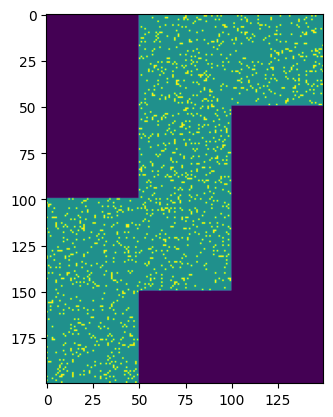

In [163]:
draw(fields)

In [320]:
def get_wrapped_pos_B(pos, direction, minmax):
    min_row, max_row, min_col, max_col = minmax
    y = int(pos.imag)
    x = int(pos.real)
    
    match direction:    
        case 1:
            if x > max_row[y]:
                if y <= 50: # enters (2, 2) from the right inverted
                    # print(1)
                    return 100 + (151 - y) * 1j, -1
                elif y <= 100: # e (3, 1) from the bottom
                    # print(2)
                    return (100 + (y - 50) + (50) * 1j), -1j 
                elif y <= 150: # e (3, 1) from the right inverted
                    # print(3)
                    return 150 + (51 - (y - 100)) * 1j , -1
                else: # e (2, 2) from the bottom
                    # print(4)
                    return (50 + (y - 150) + (150) * 1j), -1j
        case -1:
            if x < min_row[y]:
                if y <= 50: # e (1, 2) from the left inverted 
                    # print(5)
                    return 1 + (151 - y) * 1j, +1
                elif y <= 100: # e (1, 2) from the top
                    # print(6)
                    return (y - 50) + (101) * 1j, 1j
                elif y <= 150: # e (2, 1) from the left inverted
                    # print(7)
                    return 51 + (151 - y) * 1j, +1
                else: # e (2, 1) from the top
                    # print(8)
                    return (y - 150 + 50) + (1) * 1j, 1j
        case 1j:
            if y > max_col[x]:
                if x <= 50: # (3, 1) from the top?
                    # print(9)
                    return (100 + x) + 1j, 1j
                elif x <= 100: # (1, 4) from the right
                    # print(10)
                    return 50 + (x - 50 + 150) * 1j, -1
                elif x <= 150: # (2, 1) from the right
                    # print(11)
                    return 100 + (x - 100 + 50) * 1j, -1
                else:
                    raise
        case -1j:
            if y < min_col[x]:
                if x <= 50: # (2, 1) from the left
                    # print(12)
                    return 51 + (x + 50) * 1j, 1
                elif x <= 100: # (1, 4) from the left
                    # print(13)
                    return 1 + (x - 50 + 150) * 1j, 1
                elif x <= 150: # (1, 4) from the bottom
                    # print(14)
                    return (x - 100) + 200 * 1j, -1j
                else:
                    raise
    return pos, direction

def walk_B(fields, minmax, moves, start=None, start_dir=None):
    # print(moves)
    free, wall = fields
    min_row, max_row, min_col, max_col = minmax
    if start is None:
        pos = min_row[1] + 1j
    else:
        pos = start
    if start_dir is None:
        direction = 1
    else:
        direction = start_dir
    path = []
    for move in moves:
        # print(move, pos, direction)
        match move:
            case 'L':
                direction *= -1j
            case 'R':
                direction *= 1j
            case int(x):
                for i in range(x):
                    new_pos, new_dir = get_wrapped_pos_B(pos + direction, direction, minmax)
                    if new_pos in wall:
                        break
                    elif new_pos in free:
                        pos = new_pos
                        direction = new_dir
                        path.append(pos)
    return pos, direction, path

In [326]:
fields, minmax, moves = parse(data)
final_pos, direction, path = walk_B(fields, minmax, moves)

In [322]:
final_pos, direction

((96+104j), 1j)

In [323]:
pw = get_password(final_pos, direction)
pw

104385

In [319]:
puzzle.answer_b = pw

That's the right answer!  You are one gold star closer to collecting enough star fruit.You have completed Day 22! You can [Shareon
  Twitter
Mastodon] this victory or [Return to Your Advent Calendar].


In [324]:
fields, minmax, moves = parse(data)
free, wall = fields
free = free.union(wall)
wall = set()
fields = (free, wall)
final_pos, direction, path = walk_B(fields, minmax, [210], start=130+20j, start_dir=-1j)

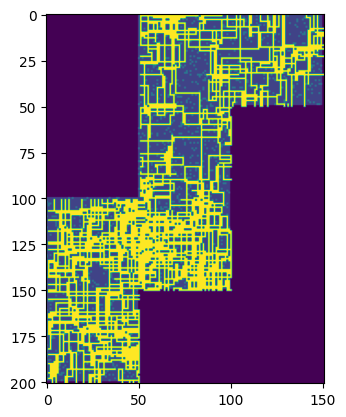

In [327]:
draw(fields, path)